# 神经网络作业

## 实验过程

### 准备阶段
首先导入必要的库

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy

加载数据集,并且定义训练和测试图像变换操作

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.RandomErasing(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

extract_path = './dataset/101_ObjectCategories'

dataset = datasets.ImageFolder(root=extract_path, transform=train_transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=48, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=48, shuffle=False)

### 定义模型

使用改进的 VGG16 模型,并初始化权重

In [6]:
class VGG16(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.5),
            
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.5),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.5),
            
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.5),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.5)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

定义训练函数和评估函数

In [ ]:
def train_model(num_epochs, model, criterion, optimizer, scheduler, train_loader, val_loader, device, patience=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    patience_counter = 0
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc='Training'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * running_corrects / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.2f}%')

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc='Validation'):
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                running_corrects += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = 100 * running_corrects / total
        
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.2f}%')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping triggered after epoch {epoch+1}')
            break

        scheduler.step()

    # Load best model weights
    model.load_state_dict(best_model_wts)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += (predicted == labels).sum().item()
            total += labels.size(0)

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = 100 * running_corrects / total
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

### 开始训练

主函数如下

Epoch 1/50
----------


Training: 100%|██████████| 267/267 [25:17<00:00,  5.69s/it]


Training Loss: 4.6078 Acc: 7.92%


Validation: 100%|██████████| 20/20 [00:54<00:00,  2.70s/it]


Validation Loss: 4.2771 Acc: 7.55%
Epoch 2/50
----------


Training: 100%|██████████| 267/267 [07:32<00:00,  1.69s/it]


Training Loss: 4.2162 Acc: 10.14%


Validation: 100%|██████████| 20/20 [00:52<00:00,  2.64s/it]


Validation Loss: 4.2297 Acc: 7.99%
Epoch 3/50
----------


Training: 100%|██████████| 267/267 [07:30<00:00,  1.69s/it]


Training Loss: 3.9230 Acc: 17.72%


Validation: 100%|██████████| 20/20 [00:52<00:00,  2.65s/it]


Validation Loss: 3.5883 Acc: 24.73%
Epoch 4/50
----------


Training: 100%|██████████| 267/267 [07:30<00:00,  1.69s/it]


Training Loss: 3.5137 Acc: 25.41%


Validation: 100%|██████████| 20/20 [00:52<00:00,  2.64s/it]


Validation Loss: 3.2915 Acc: 27.90%
Epoch 5/50
----------


Training: 100%|██████████| 267/267 [07:31<00:00,  1.69s/it]


Training Loss: 3.2416 Acc: 29.66%


Validation: 100%|██████████| 20/20 [00:53<00:00,  2.66s/it]


Validation Loss: 3.1656 Acc: 30.74%
Epoch 6/50
----------


Training: 100%|██████████| 267/267 [07:31<00:00,  1.69s/it]


Training Loss: 3.0285 Acc: 33.19%


Validation: 100%|██████████| 20/20 [00:52<00:00,  2.64s/it]


Validation Loss: 2.9740 Acc: 33.37%
Epoch 7/50
----------


Training: 100%|██████████| 267/267 [07:31<00:00,  1.69s/it]


Training Loss: 2.8634 Acc: 35.31%


Validation: 100%|██████████| 20/20 [00:53<00:00,  2.65s/it]


Validation Loss: 2.8212 Acc: 36.98%
Epoch 8/50
----------


Training: 100%|██████████| 267/267 [07:31<00:00,  1.69s/it]


Training Loss: 2.7107 Acc: 37.97%


Validation: 100%|██████████| 20/20 [00:52<00:00,  2.65s/it]


Validation Loss: 2.6549 Acc: 39.61%
Epoch 9/50
----------


Training: 100%|██████████| 267/267 [07:30<00:00,  1.69s/it]


Training Loss: 2.5863 Acc: 39.83%


Validation: 100%|██████████| 20/20 [00:52<00:00,  2.65s/it]


Validation Loss: 2.5462 Acc: 43.00%
Epoch 10/50
----------


Training: 100%|██████████| 267/267 [07:31<00:00,  1.69s/it]


Training Loss: 2.4934 Acc: 41.12%


Validation: 100%|██████████| 20/20 [00:52<00:00,  2.64s/it]


Validation Loss: 2.5065 Acc: 43.44%
Epoch 11/50
----------


Training: 100%|██████████| 267/267 [07:32<00:00,  1.70s/it]


Training Loss: 2.4635 Acc: 41.84%


Validation: 100%|██████████| 20/20 [00:53<00:00,  2.65s/it]


Validation Loss: 2.5058 Acc: 43.76%
Epoch 12/50
----------


Training: 100%|██████████| 267/267 [07:32<00:00,  1.70s/it]


Training Loss: 2.4673 Acc: 41.64%


Validation: 100%|██████████| 20/20 [00:52<00:00,  2.64s/it]


Validation Loss: 2.4840 Acc: 43.87%
Epoch 13/50
----------


Training: 100%|██████████| 267/267 [07:31<00:00,  1.69s/it]


Training Loss: 2.4776 Acc: 41.69%


Validation: 100%|██████████| 20/20 [00:52<00:00,  2.64s/it]


Validation Loss: 2.4699 Acc: 44.09%
Epoch 14/50
----------


Training: 100%|██████████| 267/267 [07:30<00:00,  1.69s/it]


Training Loss: 2.4868 Acc: 41.36%


Validation: 100%|██████████| 20/20 [00:52<00:00,  2.64s/it]


Validation Loss: 2.4562 Acc: 44.42%
Epoch 15/50
----------


Training: 100%|██████████| 267/267 [07:37<00:00,  1.71s/it]


Training Loss: 2.4792 Acc: 41.27%


Validation: 100%|██████████| 20/20 [00:53<00:00,  2.70s/it]


Validation Loss: 2.4356 Acc: 42.01%
Epoch 16/50
----------


Training: 100%|██████████| 267/267 [07:31<00:00,  1.69s/it]


Training Loss: 2.4692 Acc: 41.70%


Validation: 100%|██████████| 20/20 [00:52<00:00,  2.65s/it]


Validation Loss: 2.4496 Acc: 42.56%
Epoch 17/50
----------


Training: 100%|██████████| 267/267 [07:31<00:00,  1.69s/it]


Training Loss: 2.4481 Acc: 41.94%


Validation: 100%|██████████| 20/20 [00:52<00:00,  2.64s/it]


Validation Loss: 2.3469 Acc: 45.40%
Epoch 18/50
----------


Training: 100%|██████████| 267/267 [07:31<00:00,  1.69s/it]


Training Loss: 2.3762 Acc: 43.03%


Validation: 100%|██████████| 20/20 [00:53<00:00,  2.65s/it]


Validation Loss: 2.2753 Acc: 46.39%
Epoch 19/50
----------


Training: 100%|██████████| 267/267 [07:31<00:00,  1.69s/it]


Training Loss: 2.3507 Acc: 44.03%


Validation: 100%|██████████| 20/20 [00:52<00:00,  2.64s/it]


Validation Loss: 2.2402 Acc: 47.48%
Epoch 20/50
----------


Training: 100%|██████████| 267/267 [07:30<00:00,  1.69s/it]


Training Loss: 2.2613 Acc: 45.41%


Validation: 100%|██████████| 20/20 [00:52<00:00,  2.64s/it]


Validation Loss: 2.1806 Acc: 49.23%
Epoch 21/50
----------


Training: 100%|██████████| 267/267 [07:31<00:00,  1.69s/it]


Training Loss: 2.2029 Acc: 45.89%


Validation: 100%|██████████| 20/20 [00:52<00:00,  2.65s/it]


Validation Loss: 2.2768 Acc: 47.05%
Epoch 22/50
----------


Training: 100%|██████████| 267/267 [07:31<00:00,  1.69s/it]


Training Loss: 2.1203 Acc: 48.41%


Validation: 100%|██████████| 20/20 [00:52<00:00,  2.64s/it]


Validation Loss: 2.1420 Acc: 49.89%
Epoch 23/50
----------


Training: 100%|██████████| 267/267 [05:08<00:00,  1.16s/it]


Training Loss: 2.0212 Acc: 50.16%


Validation: 100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


Validation Loss: 2.0430 Acc: 52.08%
Epoch 24/50
----------


Training: 100%|██████████| 267/267 [03:07<00:00,  1.42it/s]


Training Loss: 1.8828 Acc: 53.11%


Validation: 100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


Validation Loss: 1.9943 Acc: 53.39%
Epoch 25/50
----------


Training: 100%|██████████| 267/267 [03:06<00:00,  1.43it/s]


Training Loss: 1.7570 Acc: 55.53%


Validation: 100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Validation Loss: 1.8500 Acc: 55.36%
Epoch 26/50
----------


Training: 100%|██████████| 267/267 [03:06<00:00,  1.43it/s]


Training Loss: 1.5785 Acc: 59.66%


Validation: 100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Validation Loss: 1.8121 Acc: 56.46%
Epoch 27/50
----------


Training: 100%|██████████| 267/267 [03:06<00:00,  1.43it/s]


Training Loss: 1.3975 Acc: 63.89%


Validation: 100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Validation Loss: 1.6608 Acc: 59.96%
Epoch 28/50
----------


Training: 100%|██████████| 267/267 [03:05<00:00,  1.44it/s]


Training Loss: 1.2025 Acc: 68.47%


Validation: 100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Validation Loss: 1.5808 Acc: 61.93%
Epoch 29/50
----------


Training: 100%|██████████| 267/267 [03:06<00:00,  1.43it/s]


Training Loss: 1.0573 Acc: 72.09%


Validation: 100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Validation Loss: 1.5219 Acc: 64.22%
Epoch 30/50
----------


Training: 100%|██████████| 267/267 [03:08<00:00,  1.42it/s]


Training Loss: 0.9704 Acc: 74.11%


Validation: 100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Validation Loss: 1.5112 Acc: 64.44%
Epoch 31/50
----------


Training: 100%|██████████| 267/267 [03:06<00:00,  1.43it/s]


Training Loss: 0.9386 Acc: 75.03%


Validation: 100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Validation Loss: 1.5105 Acc: 64.77%
Epoch 32/50
----------


Training: 100%|██████████| 267/267 [03:06<00:00,  1.43it/s]


Training Loss: 0.9481 Acc: 75.25%


Validation: 100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Validation Loss: 1.5001 Acc: 64.66%
Epoch 33/50
----------


Training: 100%|██████████| 267/267 [03:05<00:00,  1.44it/s]


Training Loss: 0.9728 Acc: 73.92%


Validation: 100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


Validation Loss: 1.5145 Acc: 63.13%
Epoch 34/50
----------


Training: 100%|██████████| 267/267 [03:06<00:00,  1.44it/s]


Training Loss: 1.0654 Acc: 71.45%


Validation: 100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


Validation Loss: 1.5966 Acc: 61.38%
Epoch 35/50
----------


Training: 100%|██████████| 267/267 [03:06<00:00,  1.44it/s]


Training Loss: 1.2049 Acc: 68.30%


Validation: 100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Validation Loss: 1.6801 Acc: 59.52%
Epoch 36/50
----------


Training: 100%|██████████| 267/267 [03:06<00:00,  1.44it/s]


Training Loss: 1.3767 Acc: 63.30%


Validation: 100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


Validation Loss: 1.8712 Acc: 54.27%
Epoch 37/50
----------


Training: 100%|██████████| 267/267 [03:05<00:00,  1.44it/s]


Training Loss: 1.5176 Acc: 60.09%


Validation: 100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


Validation Loss: 1.8032 Acc: 56.89%
Early stopping triggered after epoch 37


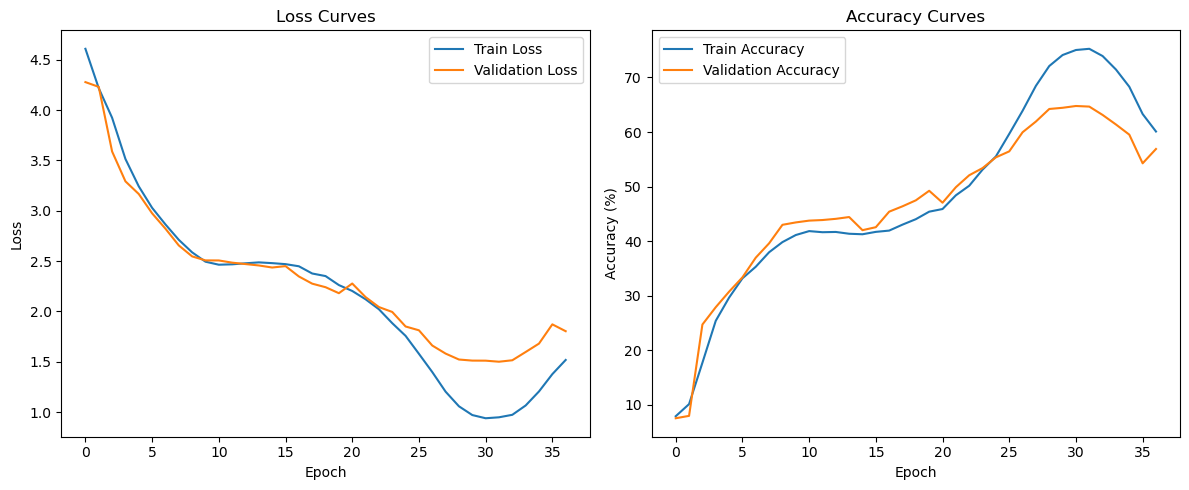

Testing: 100%|██████████| 39/39 [00:40<00:00,  1.04s/it]

Test Loss: 1.5410, Test Accuracy: 61.26%


In [ ]:
num_classes = len(dataset.classes)
model = VGG16(num_classes=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-2)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)
train_model(epochs, model, criterion, optimizer, scheduler, train_loader, val_loader, device, patience=5)
evaluate_model(model, test_loader, criterion, device)